In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

from pointprocess import *
from lightning_setup import *
%matplotlib inline

EPK only because that is the area for which we have precipitable water data

In [2]:
c = Region(city=cities['cedar'])
c.SUBSETTED = False
c.CENTER = (37.7, -111.8)
c.RADIUS = 0.6
c.define_grid()

version1 = pd.HDFStore('./output/Version1/store.h5')

In [3]:
def read_IPW(fname):
    '''Return pd.Series containing precipitable water'''

    def dateparser(y, j, t):
        x = ' '.join([y, str(int(float(j))), t])
        return pd.datetime.strptime(x, '%Y %j %H:%M:%S')

    df = pd.read_csv(fname, delim_whitespace=True, skiprows=[1], na_values=[-9.99],
                     parse_dates={'time': [1,2,3]}, date_parser=dateparser, index_col='time')

    ipw = df.IPW
    return ipw

In [4]:
ipw = read_IPW('./input/pwv147215720409387.txt')

In [5]:
def get_cox_df(c, ipw, year, thresh=1):
    '''Return yearly intermittency cox df'''
    
    from collections import OrderedDict
    
    ds = c.get_ds(y=year, filter_CG=dict(method='less_than', amax=-10), func=None)
    
    # get every threshold^th time. 
    times = pd.DatetimeIndex(ds.time.values)[::thresh]
    ds.close()

    # convert to decimal day of year
    decimal_doy = (times.dayofyear +
                   times.hour/24. +
                   times.minute/(60*24.) +
                   times.second/(60*60*24.) +
                   times.nanosecond/(10000000*60*60*24.))
    
    # find nearest precipitable water value
    ipw_nearest = ipw.reindex(times, method='nearest')

    # create an dataframe with the year, day of year, duration before threshold
    # is reached and the nearest precipitable water value
    d = {'YYYY': times.year[1:],
         'DOY': times.dayofyear[1:],
         'DURATION': decimal_doy[1:]-decimal_doy[:-1],
         'EVENT': 1,  
         'X1': ipw_nearest[1:]}
    OD = OrderedDict([(k, d[k]) for k in ['DURATION', 'EVENT', 'X1', 'DOY']])
    cox_df = pd.DataFrame(OD)

    # drop any times when there is no precipitable water value
    cox_df.dropna(how='any', inplace=True)
    
    return cox_df

In [35]:
%%time
cox_df_10 = pd.concat([get_cox_df(c, ipw, year, 10) for year in range(2010,2016)])

CPU times: user 55.2 s, sys: 1.4 s, total: 56.6 s
Wall time: 54.4 s


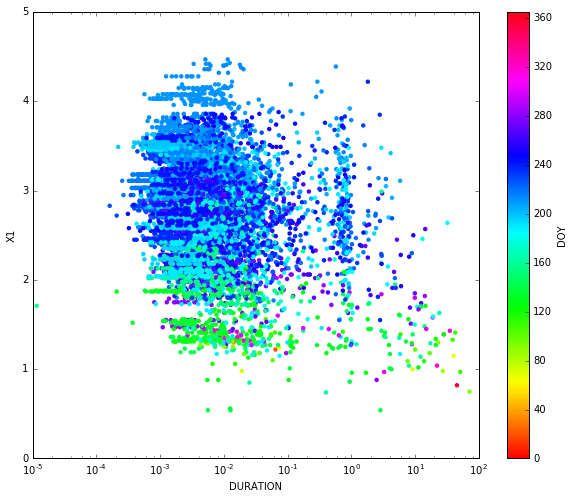

In [38]:
cox_df_10[cox_df_10['DURATION']>0].plot.scatter(
                    x='DURATION', y='X1', c='DOY', sharex=False, logx=True,
                    cmap='hsv', vmin=0, vmax=365, edgecolor='None', figsize=(10,8));

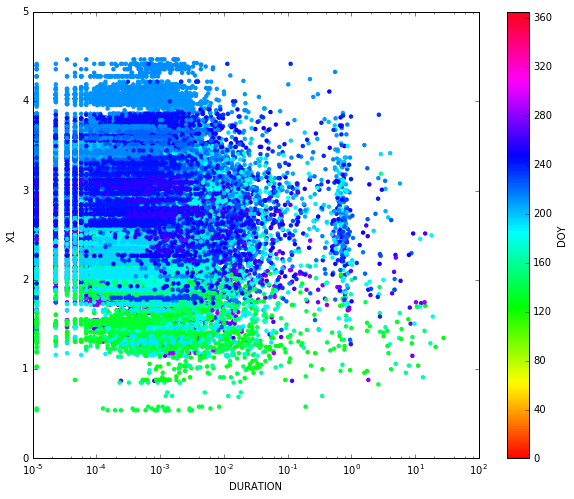

In [34]:
cox_df[(cox_df['DURATION']>0) & ((cox_df['DOY']>120) & (cox_df['DOY']<290))].plot.scatter(
                    x='DURATION', y='X1', c='DOY', sharex=False, logx=True,
                    cmap='hsv', vmin=0, vmax=365, edgecolor='None', figsize=(10,8));

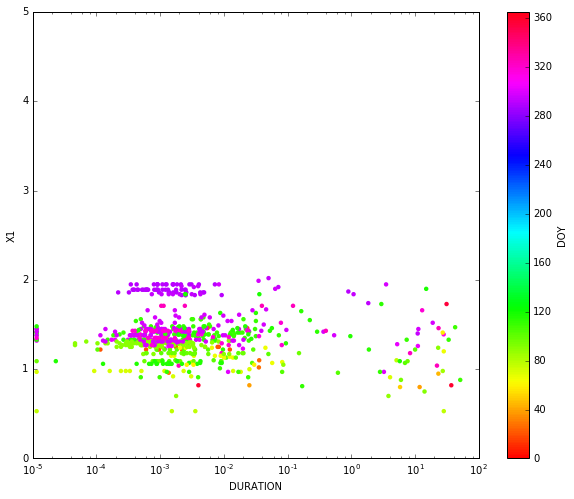

In [33]:
ax = cox_df[(cox_df['DURATION']>0) & ((cox_df['DOY']<120) | (cox_df['DOY']>290))].plot.scatter(
                    x='DURATION', y='X1', c='DOY', sharex=False, logx=True,
                    cmap='hsv', vmin=0, vmax=365, edgecolor='None', figsize=(10,8))
ax.set_ylim(0,5);

In [42]:
from lifelines import CoxPHFitter
cf = CoxPHFitter()

In [43]:
cf.fit(cox_df_10, 'DURATION', 'EVENT')

<lifelines.CoxPHFitter: fitted with 9479 observations, 0 censored>

In [44]:
cf.print_summary()

n=9479, number of events=9479

         coef  exp(coef)  se(coef)         z          p  lower 0.95  upper 0.95     
X1  2.378e-01  1.268e+00 9.939e-03 2.392e+01 1.857e-126   2.183e-01   2.572e-01  ***
DOY 1.533e-03  1.002e+00 9.802e-03 1.564e-01  8.757e-01  -1.768e-02   2.075e-02     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.575


In [50]:
version1['cox_df'] = cox_df

In [51]:
version1['cox_df_10'] = cox_df_10

In [52]:
version1.close()